In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
import h5py
import os
import tqdm
import scipy
from scipy import signal
from tqdm import tnrange
import seaborn as sns
from scipy.stats import norm,entropy,linregress
from scipy.optimize import minimize, curve_fit
from scipy.io import savemat
import multiprocess as mp
from multiprocess import Pool
import sys
import warnings
warnings.filterwarnings('ignore')
sns.set_context('poster', font_scale=1.1)
from odor_breathing_functions import*
cmap = plt.rcParams['axes.prop_cycle'].by_key()['color']
modulename = 'multiprocess'

mpl.rcParams['svg.fonttype'] = 'none'
sns.set_context('poster', font_scale=1.1)

In [3]:
path = os.getcwd() + '/Session/'


def get_pulses(choices,cum_odor,min_pulse,max_pulse):
    all_Nps = np.ceil(cum_odor).astype(np.int)
    ind_selected = np.logical_and(all_Nps>=min_pulse,all_Nps<=max_pulse)
    return choices[ind_selected], all_Nps[ind_selected]

In [4]:
def get_session_odor(array, time):
    num_trials = len(array)
    trial_odor = np.zeros((num_trials,time))
    
    for i_trial in range(num_trials):
        odor_command = array[i_trial][:time]
        trial_odor[i_trial,:] = odor_command
        
    return trial_odor

def get_odor_profile_modified(session, time):
    num_trials = session['num_trials']
    conv_odor = np.zeros((num_trials,5000))
    kernel = np.load('odor_kernel_50ms.npy')

    for i_trial in range(num_trials):
        odor_command = session['trial_odor'][i_trial][:time]
        pulse_onsets = (np.diff(odor_command)>0).astype(np.float)
        pulse_onsets_shifted = np.concatenate((np.zeros((70,)),pulse_onsets,np.zeros(131)))
        odor_profile_actual = np.convolve(pulse_onsets_shifted,kernel,mode='same')
    
    conv_odor[i_trial,:] = odor_profile_actual
    return conv_odor

In [5]:
def get_conv_odor(session):
    num_trials = session['num_trials']
    conv_odor = np.zeros((num_trials,5000))
    conv_weights_all = np.zeros((num_trials,5000))
    sniff_kernel = np.load('inhalation_kernel_fine_weights_active.npy')
    sniff_kernel = sniff_kernel/sniff_kernel.mean()
    for i_trial in range(num_trials):
        sniff_raw = np.append(session['trial_pre_breath'][i_trial],session['trial_breath'][i_trial])
        sniff = butter_lowpass_filter(sniff_raw,10,1000,3)
        sniff = (sniff - sniff.mean() +1)/2
        sniff_onset,_ = scipy.signal.find_peaks(sniff,distance=120)
        sniff_onset = sniff_onset[sniff_onset>2250]
        sniff_onset = sniff_onset[sniff_onset<7750]
        sniff_markers = np.zeros((10000,))
        conv_weights = np.zeros((10000,))
        for i in range(len(sniff_onset)-1):
            nsample = sniff_onset[i+1]-sniff_onset[i]
            conv_weights[sniff_onset[i]:sniff_onset[i+1]] = scipy.signal.resample(sniff_kernel,nsample)*250/nsample
        sniff_markers[sniff_onset] = 1
        sniff_sampling_epoch = sniff[2500:7500]
        conv_weights_sampling_epoch = conv_weights[2500:7500]
        odor_command = session['trial_odor'][i_trial]
        odor = get_odor_profile_actual(odor_command)[0:5000]
        odor_effective = odor*conv_weights_sampling_epoch
        conv_odor[i_trial,:] = odor_effective
        conv_weights_all[i_trial,:] = conv_weights_sampling_epoch
    return conv_odor, conv_weights_all

In [20]:
### Establishing color palettes
cmap = plt.get_cmap("tab10")
cmap_2 = sns.color_palette("rocket", 7)
cmap_3 = sns.color_palette("mako", 4)
cmap_4 = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)(np.linspace(0, 0.75, len(animal_list)))
#cmap_5 = sns.color_palette("rocket_r", as_cmap=True)
cmap_5 = sns.color_palette("rocket_r", as_cmap=True)(np.linspace(0.1, 0.8, len(animal_list)))

cmap_6 = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)(np.linspace(0, 0.8, 5))
cmap_7 = sns.color_palette("YlGn", 10)
cmap_8 = sns.color_palette("bone_r", 10)
cmap_9 = sns.color_palette("Accent", 12)
cmap_10 = sns.color_palette('bright',10)
cmap_11 = sns.color_palette('plasma',10)

greys = sns.color_palette("Greys", 10)
colors = plt.cm.get_cmap('BuGn')(np.linspace(0.4, 1, len(animal_list)))
colors = plt.cm.get_cmap('BuGn')(np.linspace(0.4, 1, len(animal_list)))
c_2 = plt.cm.get_cmap('RdPu')
blue_palette = sns.dark_palette(cmap(0),n_colors=9, reverse=True)
orange_palette = sns.dark_palette(cmap(1),n_colors=9, reverse=True)
red_palette = sns.dark_palette(cmap(3),n_colors=9, reverse=True)

cmap_5

array([[0.96739773, 0.77451297, 0.65057302, 1.        ],
       [0.96201757, 0.58647675, 0.42491751, 1.        ],
       [0.94291042, 0.37549479, 0.26369821, 1.        ],
       [0.85742602, 0.1622583 , 0.27627462, 1.        ],
       [0.684863  , 0.09085633, 0.34914061, 1.        ],
       [0.49083761, 0.11998161, 0.35111537, 1.        ],
       [0.29977678, 0.11356089, 0.29254823, 1.        ]])

In [9]:
num_bins = 20
half_num_bins = 8
min_pulse = 1
max_pulse = 20

pulse_bins = np.linspace(min_pulse,max_pulse,max_pulse-min_pulse+1)
phigh_list = list()
performance_list = list()
bin_counts_list = list()
all_trial_odor_list_1_25 = list()
all_high_choices_list_1_25 = list()
all_cum_odor_list_1_25 = list()
all_correct_trials_list_1_25 = list()


animal_list = [['Tabby'],['Bengal'],['Shorthair'],['Banner'],['Natasha'],['Stark'],['Peterparker']] #]#['Bengal'],['Shorthair'],['Tabby'],
#type(animal_list)

for animals in animal_list:
    fname_list = list()

    for date_number in range(20190419,20220526):
        for animal in animals:
            for session_id in range(0,10):
                session_string = str(session_id)
                date_string = str(date_number)
                fname = animal + '_' + date_string + '_' + session_string + '.pickle'
                cell_fname = path + 'session_' + fname
                if os.path.isfile(cell_fname):
                    fname_list.append(fname)

    num_all_trials = 0

    all_cum_odor = np.zeros((0,))
    all_high_trials = np.zeros((0,))
    all_high_choices = np.zeros((0,))
    all_correct_trials = np.zeros((0,))
    all_trial_odor = np.zeros((0,1250))
    all_conv_odor = np.zeros((0,1250))

    #print(fname_list)
    
    for i_file in range(len(fname_list)):
        session_id = 0
        fname = fname_list[i_file]
        session_fname = path + 'session_' + fname
        if os.path.isfile(session_fname):  #if os.path.isfile(session_fname):
            #print('holaz')
            with open(session_fname,'rb') as handle:
                session_list = pickle.load(handle)
                session = session_list[0]
                #print(session_list[0])
                if session_list[0]['type'] == 'random':
                    if session_list[0]['delay_time'] == 1.25:
                        if round(session_list[0]['high_count']/session_list[0]['low_count']) == 3:
                        #if session_list[0]['low_count'] < 5:


                            num_trials = session['num_trials']
                            #print(session_fname, session_list[0]['high_count'], session_list[0]['low_count'])
                            non_idle_trials = np.invert(session['idle_trials'])
                            #print(len(non_idle_trials))


                            correct_trials = session['correct_trials'][non_idle_trials]
                            high_trials = session['high_trials'][non_idle_trials]
                            low_trials = session['low_trials'][non_idle_trials]
                            high_choices = (correct_trials==high_trials)
                            trial_odor = session['trial_odor'][non_idle_trials]
                            cum_odor = trial_odor.sum(axis=1)/5000
                            #session_odor = get_session_odor(trial_odor, 1250)
                            session['conv_trial_odor'],session['conv_weights'] = get_conv_odor(session)
                            #conv_odor = session['conv_trial_odor']


                            all_correct_trials = np.append(all_correct_trials,correct_trials)
                            all_high_trials = np.append(all_high_trials,high_trials)
                            all_high_choices = np.append(all_high_choices,high_choices)
                            all_cum_odor = np.append(all_cum_odor,cum_odor)
                            all_trial_odor = np.append(all_trial_odor, trial_odor[:,:1250], axis=0)
                            
        high_seven = all_cum_odor>8
        low_eight = all_cum_odor<=8
        all_low_trials = np.invert(all_high_trials.astype(np.bool))
        bad_trials_1 = np.logical_and(high_seven,all_low_trials)
        bad_trials_2 = np.logical_and(low_eight,all_high_trials)
        bad_trials = np.logical_or(bad_trials_1,bad_trials_2)
        good_trials = np.invert(bad_trials)
        all_correct_trials = all_correct_trials[good_trials]
        all_high_trials = all_high_trials[good_trials]
        all_high_choices = all_high_choices[good_trials]
        all_cum_odor = all_cum_odor[good_trials]
        all_trial_odor = all_trial_odor[good_trials,:]
        #print(len(all_low_trials), bad_trials.sum(), good_trials.sum())    
    all_trial_odor_list_1_25.append(all_trial_odor)
    all_correct_trials_list_1_25.append(all_correct_trials)
    all_high_choices_list_1_25.append(all_high_choices)
    all_cum_odor_list_1_25.append(all_cum_odor)

    phigh = np.zeros((num_bins,2))
    performance = np.zeros((num_bins,2))
    bin_counts = np.zeros((num_bins,))
    pulse_bin_ind = np.ceil(all_cum_odor).astype(np.int)

    for i in range(num_bins):
        selected = all_high_choices[pulse_bin_ind==pulse_bins[i]]
        selected_correct = all_correct_trials[pulse_bin_ind==pulse_bins[i]]
        num_selected = len(selected)
        bin_counts[i] = num_selected
        phigh[i,0] = selected.mean()
        phigh[i,1] = 1.69*selected.std()/np.sqrt(num_selected)
        performance[i,0] = selected_correct.mean()
        performance[i,1] = 1.69*selected_correct.std()/np.sqrt(num_selected)
    phigh_list.append(phigh)
    performance_list.append(performance)
    bin_counts_list.append(bin_counts)

In [8]:
from itertools import chain

def flatten_chain(matrix):
    return list(chain.from_iterable(matrix))

In [251]:
len(flatten_chain(all_correct_trials_list_10))

2715

In [25]:
conv_odor_trial

array([0., 0., 0., ..., 0., 0., 0.])

In [10]:
pool_correct_trials = np.zeros((0,))
pool_high_choices = np.zeros((0,))
pool_cum_odor = np.zeros((0,))
perc_int_list = list()
int_list = list()

for i in range(len(all_correct_trials_list_1_25)):
    pool_correct_trials = np.append(pool_correct_trials,all_correct_trials_list_1_25[i])
    pool_high_choices = np.append(pool_high_choices,all_high_choices_list_1_25[i])
    pool_cum_odor = np.append(pool_cum_odor,all_cum_odor_list_1_25[i])
    odor_animal = all_trial_odor_list_1_25[i]

    for j in range(len(odor_animal)):
        conv_odor_trial = odor_animal[j]
        perceived_intermittency = (conv_odor_trial[:] > 0).mean()
        perc_int_list.append(perceived_intermittency)


phigh_1_25 = np.zeros((num_bins,2))
performance = np.zeros((num_bins,2))
intermittency_1_25 = np.zeros((num_bins,2))
bin_counts_1_25 = np.zeros((num_bins,))
pulse_bin_ind = np.ceil(pool_cum_odor).astype(np.int)
perc_int = np.asarray(perc_int_list)

for i in range(num_bins):
    selected = pool_high_choices[pulse_bin_ind==pulse_bins[i]]
    selected_correct = pool_correct_trials[pulse_bin_ind==pulse_bins[i]]
    selected_int = perc_int[pulse_bin_ind==pulse_bins[i]]
    num_selected = len(selected)
    bin_counts_1_25[i] = num_selected
    phigh_1_25[i,0] = selected.mean()
    phigh_1_25[i,1] = 1.96*selected.std()/np.sqrt(num_selected)
    performance[i,0] = selected_correct.mean()
    performance[i,1] = 1.96*selected_correct.std()/np.sqrt(num_selected)
    intermittency_1_25[i,0] = selected_int.mean()
    intermittency_1_25[i,1] = 1.69*selected_int.std()/np.sqrt(num_selected)


In [11]:
num_bins = 20
half_num_bins = 8
min_pulse = 1
max_pulse = 20

pulse_bins = np.linspace(min_pulse,max_pulse,max_pulse-min_pulse+1)
phigh_list = list()
performance_list = list()
bin_counts_list = list()
all_trial_odor_list_2_5 = list()
all_high_choices_list_2_5 = list()
all_cum_odor_list_2_5 = list()
all_correct_trials_list_2_5 = list()


animal_list = [['Tabby'],['Bengal'],['Shorthair'],['Banner'],['Natasha'],['Stark'],['Peterparker']] #]#['Bengal'],['Shorthair'],['Tabby'],
#type(animal_list)

for animals in animal_list:
    fname_list = list()

    for date_number in range(20190419,20220526):
        for animal in animals:
            for session_id in range(0,10):
                session_string = str(session_id)
                date_string = str(date_number)
                fname = animal + '_' + date_string + '_' + session_string + '.pickle'
                cell_fname = path + 'session_' + fname
                if os.path.isfile(cell_fname):
                    fname_list.append(fname)

    num_all_trials = 0

    all_cum_odor = np.zeros((0,))
    all_high_trials = np.zeros((0,))
    all_high_choices = np.zeros((0,))
    all_correct_trials = np.zeros((0,))
    all_trial_odor = np.zeros((0,2500))


    #print(fname_list)
    
    for i_file in range(len(fname_list)):
        session_id = 0
        fname = fname_list[i_file]
        session_fname = path + 'session_' + fname
        if os.path.isfile(session_fname):  #if os.path.isfile(session_fname):
            #print('holaz')
            with open(session_fname,'rb') as handle:
                session_list = pickle.load(handle)
                session = session_list[0]
                #print(session_list[0])
                if session_list[0]['type'] == 'random':
                    if session_list[0]['delay_time'] == 2.5:
                        if round(session_list[0]['high_count']/session_list[0]['low_count']) == 3:
                        #if session_list[0]['low_count'] < 5:


                            num_trials = session['num_trials']
                            #print(session_fname, session_list[0]['high_count'], session_list[0]['low_count'])
                            non_idle_trials = np.invert(session['idle_trials'])
                            #print(len(non_idle_trials))


                            correct_trials = session['correct_trials'][non_idle_trials]
                            high_trials = session['high_trials'][non_idle_trials]
                            low_trials = session['low_trials'][non_idle_trials]
                            high_choices = (correct_trials==high_trials)
                            trial_odor = session['trial_odor'][non_idle_trials]
                            cum_odor = trial_odor.sum(axis=1)/5000



                            all_correct_trials = np.append(all_correct_trials,correct_trials)
                            all_high_trials = np.append(all_high_trials,high_trials)
                            all_high_choices = np.append(all_high_choices,high_choices)
                            all_cum_odor = np.append(all_cum_odor,cum_odor)
                            all_trial_odor = np.append(all_trial_odor, trial_odor[:,:2500], axis=0)

            
        high_seven = all_cum_odor>8
        low_eight = all_cum_odor<=8
        all_low_trials = np.invert(all_high_trials.astype(np.bool))
        bad_trials_1 = np.logical_and(high_seven,all_low_trials)
        bad_trials_2 = np.logical_and(low_eight,all_high_trials)
        bad_trials = np.logical_or(bad_trials_1,bad_trials_2)
        good_trials = np.invert(bad_trials)
        all_correct_trials = all_correct_trials[good_trials]
        all_high_trials = all_high_trials[good_trials]
        all_high_choices = all_high_choices[good_trials]
        all_cum_odor = all_cum_odor[good_trials]
        all_trial_odor = all_trial_odor[good_trials,:]
        #print(len(all_low_trials), bad_trials.sum(), good_trials.sum())    
    all_trial_odor_list_2_5.append(all_trial_odor)
    all_correct_trials_list_2_5.append(all_correct_trials)
    all_high_choices_list_2_5.append(all_high_choices)
    all_cum_odor_list_2_5.append(all_cum_odor)

    phigh = np.zeros((num_bins,2))
    performance = np.zeros((num_bins,2))
    bin_counts = np.zeros((num_bins,))
    pulse_bin_ind = np.ceil(all_cum_odor).astype(np.int)

    for i in range(num_bins):
        selected = all_high_choices[pulse_bin_ind==pulse_bins[i]]
        selected_correct = all_correct_trials[pulse_bin_ind==pulse_bins[i]]
        num_selected = len(selected)
        bin_counts[i] = num_selected
        phigh[i,0] = selected.mean()
        phigh[i,1] = 1.69*selected.std()/np.sqrt(num_selected)
        performance[i,0] = selected_correct.mean()
        performance[i,1] = 1.69*selected_correct.std()/np.sqrt(num_selected)
    phigh_list.append(phigh)
    performance_list.append(performance)
    bin_counts_list.append(bin_counts)

In [12]:
pool_correct_trials = np.zeros((0,))
pool_high_choices = np.zeros((0,))
pool_cum_odor = np.zeros((0,))
perc_int_list = list()
int_list = list()

for i in range(len(all_correct_trials_list_2_5)):
    pool_correct_trials = np.append(pool_correct_trials,all_correct_trials_list_2_5[i])
    pool_high_choices = np.append(pool_high_choices,all_high_choices_list_2_5[i])
    pool_cum_odor = np.append(pool_cum_odor,all_cum_odor_list_2_5[i])
    odor_animal = all_trial_odor_list_2_5[i]

    for j in range(len(odor_animal)):
        conv_odor_trial = odor_animal[j]
        perceived_intermittency = (conv_odor_trial[:] > 0).mean()
        perc_int_list.append(perceived_intermittency)

phigh_2_5 = np.zeros((num_bins,2))
performance = np.zeros((num_bins,2))
bin_counts_2_5 = np.zeros((num_bins,))
pulse_bin_ind = np.ceil(pool_cum_odor).astype(np.int)
intermittency_2_5 = np.zeros((num_bins,2))
perc_int = np.asarray(perc_int_list)

for i in range(num_bins):
    selected = pool_high_choices[pulse_bin_ind==pulse_bins[i]]
    selected_correct = pool_correct_trials[pulse_bin_ind==pulse_bins[i]]
    selected_int = perc_int[pulse_bin_ind==pulse_bins[i]]

    num_selected = len(selected)
    bin_counts_2_5[i] = num_selected
    phigh_2_5[i,0] = selected.mean()
    phigh_2_5[i,1] = 1.96*selected.std()/np.sqrt(num_selected)
    performance[i,0] = selected_correct.mean()
    performance[i,1] = 1.96*selected_correct.std()/np.sqrt(num_selected)
    intermittency_2_5[i,0] = selected_int.mean()
    intermittency_2_5[i,1] = 1.69*selected_int.std()/np.sqrt(num_selected)

In [13]:
num_bins = 20
half_num_bins = 8
min_pulse = 1
max_pulse = 20

pulse_bins = np.linspace(min_pulse,max_pulse,max_pulse-min_pulse+1)
phigh_list = list()
performance_list = list()
bin_counts_list = list()
all_trial_odor_list_5 = list()
all_high_choices_list_5 = list()
all_cum_odor_list_5 = list()
all_correct_trials_list_5 = list()


animal_list = [['Tabby'],['Bengal'],['Shorthair'],['Banner'],['Natasha'],['Stark'],['Peterparker']] #]#['Bengal'],['Shorthair'],['Tabby'],
#type(animal_list)

for animals in animal_list:
    fname_list = list()

    for date_number in range(20190419,20220526):
        for animal in animals:
            for session_id in range(0,10):
                session_string = str(session_id)
                date_string = str(date_number)
                fname = animal + '_' + date_string + '_' + session_string + '.pickle'
                cell_fname = path + 'session_' + fname
                if os.path.isfile(cell_fname):
                    fname_list.append(fname)

    num_all_trials = 0

    all_cum_odor = np.zeros((0,))
    all_high_trials = np.zeros((0,))
    all_high_choices = np.zeros((0,))
    all_correct_trials = np.zeros((0,))
    all_trial_odor = np.zeros((0,5000))


    #print(fname_list)
    
    for i_file in range(len(fname_list)):
        session_id = 0
        fname = fname_list[i_file]
        session_fname = path + 'session_' + fname
        if os.path.isfile(session_fname):  #if os.path.isfile(session_fname):
            #print('holaz')
            with open(session_fname,'rb') as handle:
                session_list = pickle.load(handle)
                session = session_list[0]
                #print(session_list[0])
                if session_list[0]['type'] == 'random':
                    if session_list[0]['delay_time'] == 5:
                        if round(session_list[0]['high_count']/session_list[0]['low_count']) == 3:
                        #if session_list[0]['low_count'] < 5:


                            num_trials = session['num_trials']
                            #print(session_fname, session_list[0]['high_count'], session_list[0]['low_count'])
                            non_idle_trials = np.invert(session['idle_trials'])
                            #print(len(non_idle_trials))


                            correct_trials = session['correct_trials'][non_idle_trials]
                            high_trials = session['high_trials'][non_idle_trials]
                            low_trials = session['low_trials'][non_idle_trials]
                            high_choices = (correct_trials==high_trials)
                            trial_odor = session['trial_odor'][non_idle_trials]
                            cum_odor = trial_odor.sum(axis=1)/5000



                            all_correct_trials = np.append(all_correct_trials,correct_trials)
                            all_high_trials = np.append(all_high_trials,high_trials)
                            all_high_choices = np.append(all_high_choices,high_choices)
                            all_cum_odor = np.append(all_cum_odor,cum_odor)
                            all_trial_odor = np.append(all_trial_odor, trial_odor[:,:5000], axis=0)

            
        high_seven = all_cum_odor>8
        low_eight = all_cum_odor<=8
        all_low_trials = np.invert(all_high_trials.astype(np.bool))
        bad_trials_1 = np.logical_and(high_seven,all_low_trials)
        bad_trials_2 = np.logical_and(low_eight,all_high_trials)
        bad_trials = np.logical_or(bad_trials_1,bad_trials_2)
        good_trials = np.invert(bad_trials)
        all_correct_trials = all_correct_trials[good_trials]
        all_high_trials = all_high_trials[good_trials]
        all_high_choices = all_high_choices[good_trials]
        all_cum_odor = all_cum_odor[good_trials]
        all_trial_odor = all_trial_odor[good_trials,:]
        #print(len(all_low_trials), bad_trials.sum(), good_trials.sum())
    all_trial_odor_list_5.append(all_trial_odor)
    all_correct_trials_list_5.append(all_correct_trials)
    all_high_choices_list_5.append(all_high_choices)
    all_cum_odor_list_5.append(all_cum_odor)

    phigh = np.zeros((num_bins,2))
    performance = np.zeros((num_bins,2))
    bin_counts = np.zeros((num_bins,))
    pulse_bin_ind = np.ceil(all_cum_odor).astype(np.int)

    for i in range(num_bins):
        selected = all_high_choices[pulse_bin_ind==pulse_bins[i]]
        selected_correct = all_correct_trials[pulse_bin_ind==pulse_bins[i]]
        num_selected = len(selected)
        bin_counts[i] = num_selected
        phigh[i,0] = selected.mean()
        phigh[i,1] = 1.69*selected.std()/np.sqrt(num_selected)
        performance[i,0] = selected_correct.mean()
        performance[i,1] = 1.69*selected_correct.std()/np.sqrt(num_selected)
    phigh_list.append(phigh)
    performance_list.append(performance)
    bin_counts_list.append(bin_counts)

In [14]:
pool_correct_trials = np.zeros((0,))
pool_high_choices = np.zeros((0,))
pool_cum_odor = np.zeros((0,))
perc_int_list = list()
int_list = list()

for i in range(len(all_correct_trials_list_5)):
    pool_correct_trials = np.append(pool_correct_trials,all_correct_trials_list_5[i])
    pool_high_choices = np.append(pool_high_choices,all_high_choices_list_5[i])
    pool_cum_odor = np.append(pool_cum_odor,all_cum_odor_list_5[i])
    odor_animal = all_trial_odor_list_5[i]

    for j in range(len(odor_animal)):
        conv_odor_trial = odor_animal[j]
        perceived_intermittency = (conv_odor_trial[:] > 0).mean()
        perc_int_list.append(perceived_intermittency)

phigh_5 = np.zeros((num_bins,2))
performance = np.zeros((num_bins,2))
bin_counts_5 = np.zeros((num_bins,))
pulse_bin_ind = np.ceil(pool_cum_odor).astype(np.int)
intermittency_5 = np.zeros((num_bins,2))
perc_int = np.asarray(perc_int_list)

for i in range(num_bins):
    selected = pool_high_choices[pulse_bin_ind==pulse_bins[i]]
    selected_correct = pool_correct_trials[pulse_bin_ind==pulse_bins[i]]
    selected_int = perc_int[pulse_bin_ind==pulse_bins[i]]
    num_selected = len(selected)
    bin_counts_5[i] = num_selected
    phigh_5[i,0] = selected.mean()
    phigh_5[i,1] = 1.96*selected.std()/np.sqrt(num_selected)
    performance[i,0] = selected_correct.mean()
    performance[i,1] = 1.96*selected_correct.std()/np.sqrt(num_selected)
    intermittency_5[i,0] = selected_int.mean()
    intermittency_5[i,1] = 1.69*selected_int.std()/np.sqrt(num_selected)

In [15]:
num_bins = 20
half_num_bins = 8
min_pulse = 1
max_pulse = 20

pulse_bins = np.linspace(min_pulse,max_pulse,max_pulse-min_pulse+1)
phigh_list = list()
performance_list = list()
bin_counts_list = list()
all_trial_odor_list_10 = list()
all_high_choices_list_10 = list()
all_cum_odor_list_10 = list()
all_correct_trials_list_10 = list()


animal_list = [['Tabby'],['Bengal'],['Shorthair'],['Banner'],['Natasha'],['Stark'],['Peterparker']] #]#['Bengal'],['Shorthair'],['Tabby'],
#type(animal_list)

for animals in animal_list:
    fname_list = list()

    for date_number in range(20190419,20220526):
        for animal in animals:
            for session_id in range(0,10):
                session_string = str(session_id)
                date_string = str(date_number)
                fname = animal + '_' + date_string + '_' + session_string + '.pickle'
                cell_fname = path + 'session_' + fname
                if os.path.isfile(cell_fname):
                    fname_list.append(fname)

    num_all_trials = 0

    all_cum_odor = np.zeros((0,))
    all_high_trials = np.zeros((0,))
    all_high_choices = np.zeros((0,))
    all_correct_trials = np.zeros((0,))
    all_trial_odor = np.zeros((0,10000))


    #print(fname_list)
    
    for i_file in range(len(fname_list)):
        session_id = 0
        fname = fname_list[i_file]
        session_fname = path + 'session_' + fname
        if os.path.isfile(session_fname):  #if os.path.isfile(session_fname):
            #print('holaz')
            with open(session_fname,'rb') as handle:
                session_list = pickle.load(handle)
                session = session_list[0]
                #print(session_list[0])
                if session_list[0]['type'] == 'random':
                    if session_list[0]['delay_time'] == 10:
                        if round(session_list[0]['high_count']/session_list[0]['low_count']) == 3:
                        #if session_list[0]['low_count'] < 5:


                            num_trials = session['num_trials']
                            #print(session_fname, session_list[0]['high_count'], session_list[0]['low_count'])
                            non_idle_trials = np.invert(session['idle_trials'])
                            #print(len(non_idle_trials))


                            correct_trials = session['correct_trials'][non_idle_trials]
                            high_trials = session['high_trials'][non_idle_trials]
                            low_trials = session['low_trials'][non_idle_trials]
                            high_choices = (correct_trials==high_trials)
                            trial_odor = session['trial_odor'][non_idle_trials]
                            cum_odor = trial_odor.sum(axis=1)/5000



                            all_correct_trials = np.append(all_correct_trials,correct_trials)
                            all_high_trials = np.append(all_high_trials,high_trials)
                            all_high_choices = np.append(all_high_choices,high_choices)
                            all_cum_odor = np.append(all_cum_odor,cum_odor)
                            all_trial_odor = np.append(all_trial_odor, trial_odor[:,:10000], axis=0)

            
        high_seven = all_cum_odor>8
        low_eight = all_cum_odor<=8
        all_low_trials = np.invert(all_high_trials.astype(np.bool))
        bad_trials_1 = np.logical_and(high_seven,all_low_trials)
        bad_trials_2 = np.logical_and(low_eight,all_high_trials)
        bad_trials = np.logical_or(bad_trials_1,bad_trials_2)
        good_trials = np.invert(bad_trials)
        all_correct_trials = all_correct_trials[good_trials]
        all_high_trials = all_high_trials[good_trials]
        all_high_choices = all_high_choices[good_trials]
        all_cum_odor = all_cum_odor[good_trials]
        all_trial_odor = all_trial_odor[good_trials,:]
        #print(len(all_low_trials), bad_trials.sum(), good_trials.sum())
    all_trial_odor_list_10.append(all_trial_odor) 
    all_correct_trials_list_10.append(all_correct_trials)
    all_high_choices_list_10.append(all_high_choices)
    all_cum_odor_list_10.append(all_cum_odor)

    phigh = np.zeros((num_bins,2))
    performance = np.zeros((num_bins,2))
    bin_counts = np.zeros((num_bins,))
    pulse_bin_ind = np.ceil(all_cum_odor).astype(np.int)

    for i in range(num_bins):
        selected = all_high_choices[pulse_bin_ind==pulse_bins[i]]
        selected_correct = all_correct_trials[pulse_bin_ind==pulse_bins[i]]
        num_selected = len(selected)
        bin_counts[i] = num_selected
        phigh[i,0] = selected.mean()
        phigh[i,1] = 1.69*selected.std()/np.sqrt(num_selected)
        performance[i,0] = selected_correct.mean()
        performance[i,1] = 1.69*selected_correct.std()/np.sqrt(num_selected)
    phigh_list.append(phigh)
    performance_list.append(performance)
    bin_counts_list.append(bin_counts)

In [16]:
pool_correct_trials = np.zeros((0,))
pool_high_choices = np.zeros((0,))
pool_cum_odor = np.zeros((0,))
perc_int_list = list()
int_list = list()

for i in range(len(all_correct_trials_list_10)):
    pool_correct_trials = np.append(pool_correct_trials,all_correct_trials_list_10[i])
    pool_high_choices = np.append(pool_high_choices,all_high_choices_list_10[i])
    pool_cum_odor = np.append(pool_cum_odor,all_cum_odor_list_10[i])
    odor_animal = all_trial_odor_list_10[i]

    for j in range(len(odor_animal)):
        conv_odor_trial = odor_animal[j]
        perceived_intermittency = (conv_odor_trial[:] > 0).mean()
        perc_int_list.append(perceived_intermittency)

phigh_10 = np.zeros((num_bins,2))
performance = np.zeros((num_bins,2))
bin_counts_10 = np.zeros((num_bins,))
pulse_bin_ind = np.ceil(pool_cum_odor).astype(np.int)
intermittency_10 = np.zeros((num_bins,2))
perc_int = np.asarray(perc_int_list)

for i in range(num_bins):
    selected = pool_high_choices[pulse_bin_ind==pulse_bins[i]]
    selected_correct = pool_correct_trials[pulse_bin_ind==pulse_bins[i]]
    selected_int = perc_int[pulse_bin_ind==pulse_bins[i]]

    num_selected = len(selected)
    bin_counts_10[i] = num_selected
    phigh_10[i,0] = selected.mean()
    phigh_10[i,1] = 1.96*selected.std()/np.sqrt(num_selected)
    performance[i,0] = selected_correct.mean()
    performance[i,1] = 1.96*selected_correct.std()/np.sqrt(num_selected)
    intermittency_10[i,0] = selected_int.mean()
    intermittency_10[i,1] = 1.69*selected_int.std()/np.sqrt(num_selected)

In [17]:
savepath = os.getcwd() + '/Figures/test/'
savepath_pdf = os.getcwd() + '/Figures/test/pdf/'
savepath_png = os.getcwd() + '/Figures/test/png/'
savepath_svg = os.getcwd() + '/Figures/test/svg/'

In [18]:
nan_vec = np.array([[np.nan, np.nan],
                    [np.nan, np.nan],
                    [np.nan, np.nan],
                    [np.nan, np.nan],
                    [np.nan, np.nan],
                    [np.nan, np.nan]])

phigh_1_25_corr = np.concatenate([phigh_1_25[0:4], nan_vec, phigh_1_25[10:14]])
phigh_2_5_corr = np.concatenate([phigh_2_5[0:4], nan_vec, phigh_2_5[10:14]])
phigh_5_corr = np.concatenate([phigh_5[0:4], nan_vec, phigh_5[10:14]])
phigh_10_corr = np.concatenate([phigh_10[0:4], nan_vec, phigh_10[10:14]])



pulse_bins_corr = np.arange(1,15)
print(phigh_1_25_corr.shape)
print(pulse_bins_corr.shape)


(14, 2)
(14,)


In [193]:
np.zeros((2,3))

array([[0., 0., 0.],
       [0., 0., 0.]])

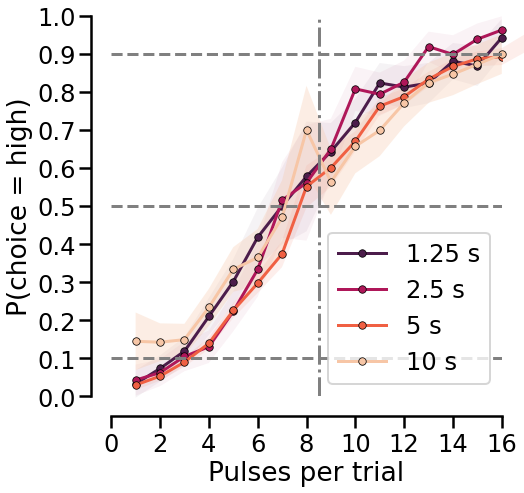

In [24]:
fig = plt.figure(figsize=(7,7))


ax = sns.lineplot(x=np.arange(1,21),y=phigh_1_25[:,0],color=cmap_5[6],  
                  marker='.',markeredgecolor='k', markersize=15, clip_on=False, label='1.25 s')

ax = sns.lineplot(x=np.arange(1,21),y=phigh_2_5[:,0],color=cmap_5[4],  
                  marker='.',markeredgecolor='k', markersize=15, clip_on=False, label='2.5 s')

ax = sns.lineplot(x=np.arange(1,21),y=phigh_5[:,0],color=cmap_5[2],  
                  marker='.',markeredgecolor='k', markersize=15, clip_on=True, label='5 s')
                  
ax = sns.lineplot(x=np.arange(1,21),y=phigh_10[:,0],color=cmap_5[0],  
                  marker='.',markeredgecolor='k', markersize=15, clip_on=False, label='10 s')
                  
plt.legend(loc=4)

ax.fill_between(np.arange(1,21), phigh_1_25[:,0] - phigh_1_25[:,1], phigh_1_25[:,0] + phigh_1_25[:,1], 
                   alpha=0.05, color=cmap_5[6], edgecolor=None, clip_on=False)

ax.fill_between(np.arange(1,21), phigh_2_5[:,0] - phigh_2_5[:,1], phigh_2_5[:,0] + phigh_2_5[:,1], 
                   alpha=0.05, color=cmap_5[4], edgecolor=None, clip_on=False)

ax.fill_between(np.arange(1,21), phigh_5[:,0] - phigh_5[:,1], phigh_5[:,0] + phigh_5[:,1], 
                   alpha=0.1, color=cmap_5[2], edgecolor=None, clip_on=False)

ax.fill_between(np.arange(1,21), phigh_10[:,0] - phigh_10[:,1], phigh_10[:,0] + phigh_10[:,1], 
                   alpha=0.3, color=cmap_5[0], edgecolor=None, clip_on=False)

plt.xlabel('Pulses per trial')  #'$N_{pulses}$'
plt.axhline(y=0.1,color='gray',linestyle='--')
plt.axhline(y=0.5,color='gray',linestyle='--')
plt.axhline(y=0.9,color='gray',linestyle='--')
plt.axvline(x=8.5,color='gray',linestyle='-.')
plt.ylim(0,1)
plt.xlim(0,16)
plt.yticks(np.linspace(0,1,11))
plt.ylabel('P(choice = high)')  #$P$(choice = left)
plt.xticks(np.linspace(0,16,9))
sns.despine(right=True, top=True, offset=20)

# fig.savefig(savepath_svg + 'c_6_behavior_summary_all_16.svg', transparent = True, format='svg', bbox_inches='tight')
# fig.savefig(savepath_png + 'c_6_behavior_summary_all_16.png', transparent = True, format='png', bbox_inches='tight')
# fig.savefig(savepath_pdf + 'c_6_behavior_summary_all_16.pdf', transparent = True, format='pdf', bbox_inches='tight')

plt.show()

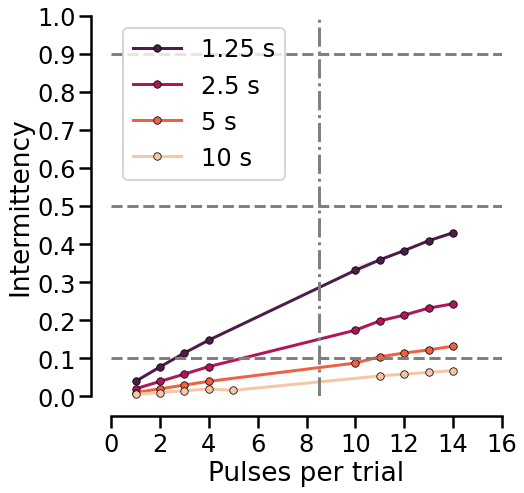

In [224]:
fig = plt.figure(figsize=(7,7))

ax = sns.lineplot(x=pulse_bins[0:20],y=intermittency_1_25[0:20,0],color=cmap_5[6],  
                  marker='.',markeredgecolor='k', markersize=15, clip_on=False, label='1.25 s')


ax = sns.lineplot(x=pulse_bins[0:20],y=intermittency_2_5[0:20,0],color=cmap_5[4],  
                  marker='.',markeredgecolor='k', markersize=15, clip_on=False, label='2.5 s')


ax = sns.lineplot(x=pulse_bins[0:20],y=intermittency_5[0:20,0],color=cmap_5[2],  
                  marker='.',markeredgecolor='k', markersize=15, clip_on=True, label='5 s')


ax = sns.lineplot(x=pulse_bins[0:20],y=intermittency_10[0:20,0],color=cmap_5[0],  
                  marker='.',markeredgecolor='k', markersize=15, clip_on=False, label='10 s')

plt.legend(loc='upper left')



ax.fill_between(pulse_bins[0:20], intermittency_1_25[0:20,0] - intermittency_1_25[0:20,1], intermittency_1_25[0:20,0] + intermittency_1_25[0:20,1], 
                   alpha=0.1, color=cmap_5[6], edgecolor=None)

ax.fill_between(pulse_bins[0:20], intermittency_2_5[0:20,0] - intermittency_2_5[0:20,1], intermittency_2_5[0:20,0] + intermittency_2_5[0:20,1], 
                   alpha=0.1, color=cmap_5[4], edgecolor=None)

ax.fill_between(pulse_bins[0:20], intermittency_5[0:20,0] - intermittency_5[0:20,1], intermittency_5[0:20,0] + intermittency_5[0:20,1], 
                   alpha=0.2, color=cmap_5[2], edgecolor=None)

ax.fill_between(pulse_bins[0:20], intermittency_10[0:20,0] - intermittency_10[0:20,1], intermittency_10[0:20,0] + intermittency_10[0:20,1], 
                   alpha=0.2, color=cmap_5[0], edgecolor=None)

plt.xlabel('Pulses per trial')  #'$N_{pulses}$'
plt.axhline(y=0.1,color='gray',linestyle='--')
plt.axhline(y=0.5,color='gray',linestyle='--')
plt.axhline(y=0.9,color='gray',linestyle='--')
plt.axvline(x=8.5,color='gray',linestyle='-.')
plt.ylim(0,1)
plt.xlim(0,16)
plt.yticks(np.linspace(0,1,11))
plt.ylabel('Intermittency')  #$P$(choice = left)
plt.xticks(np.linspace(0,16,9))
sns.despine(right=True, top=True, offset=20)

fig.savefig(savepath_svg + 'c_6_intermittency_all_16.svg', transparent = True, format='svg', bbox_inches='tight')
fig.savefig(savepath_png + 'c_6_intermittency_all_16.png', transparent = True, format='png', bbox_inches='tight')
fig.savefig(savepath_pdf + 'c_6_intermittency_all_16.pdf', transparent = True, format='pdf', bbox_inches='tight')

plt.show()

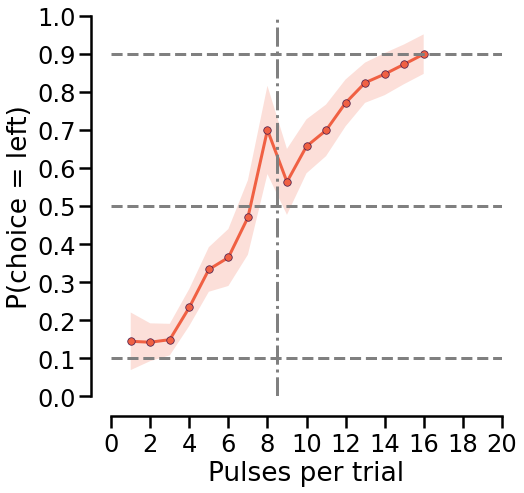

In [22]:
fig = plt.figure(figsize=(7,7))

ax = sns.lineplot(x=pulse_bins[0:20],y=phigh_10[0:20,0],color=cmap_5[2],  
                  marker='.',markeredgecolor=cmap_5[6], markersize=15, clip_on=False)
ax.fill_between(pulse_bins[0:20], phigh_10[0:20,0] - phigh_10[0:20,1], phigh_10[0:20,0] + phigh_10[0:20,1], 
                   alpha=0.2, color=cmap_5[2], edgecolor=None)

plt.xlabel('Pulses per trial')  #'$N_{pulses}$'
plt.axhline(y=0.1,color='gray',linestyle='--')
plt.axhline(y=0.5,color='gray',linestyle='--')
plt.axhline(y=0.9,color='gray',linestyle='--')
plt.axvline(x=8.5,color='gray',linestyle='-.')
plt.ylim(0,1)
plt.xlim(0,20)
plt.yticks(np.linspace(0,1,11))
plt.ylabel('P(choice = left)')  #$P$(choice = left)
plt.xticks(np.linspace(0,20,11))
sns.despine(right=True, top=True, offset=20)

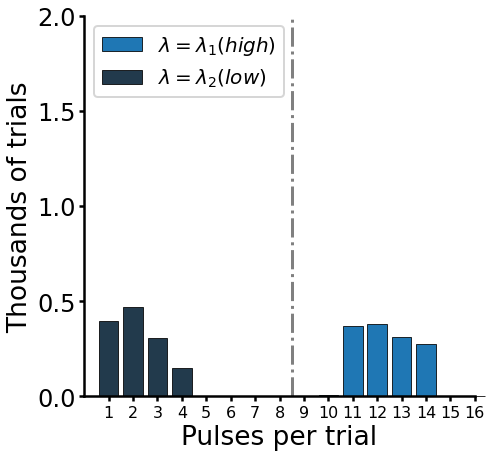

In [220]:
fig = plt.figure(figsize=(7,7))

#plt.subplot(1,2,1)

bin_counts = np.zeros((num_bins,))
for i in range(len(bin_counts_list)):
    bin_counts += bin_counts_list[i]
plt.bar(pulse_bins[half_num_bins:16],bin_counts_1_25[half_num_bins:16]/1000,color=blue_palette[0], 
        edgecolor = 'black', linewidth=0.8, clip_on=False)
plt.bar(pulse_bins[:half_num_bins],bin_counts_1_25[:half_num_bins]/1000,color=blue_palette[6], 
        edgecolor = 'black', linewidth=0.8, clip_on=False)
plt.legend(['$\lambda=\lambda_1(high)$','$\lambda=\lambda_2(low)$'], fontsize=20)
plt.grid(False)
plt.xlim(0,16)
plt.ylim(0,2)

plt.xticks(np.linspace(1,16,16), fontsize = 16)#, rotation=70)
plt.axvline(x=8.5,color='gray',linestyle='-.')
plt.xlabel('Pulses per trial')
plt.ylabel('Thousands of trials')
plt.tick_params(axis='both', length=5, color='black', direction = 'out')
sns.despine(right=True, top=True)
fig.savefig(savepath_svg + 'Histogram_of_trials_1_25s_1to6.svg',transparent=True, format='svg', bbox_inches='tight')
fig.savefig(savepath_png + 'Histogram_of_trials_1_25s_1to6.png',transparent=True, format='png', bbox_inches='tight')
fig.savefig(savepath_pdf + 'Histogram_of_trials_1_25s_1to6.pdf',transparent=True, format='pdf', bbox_inches='tight')

plt.show()

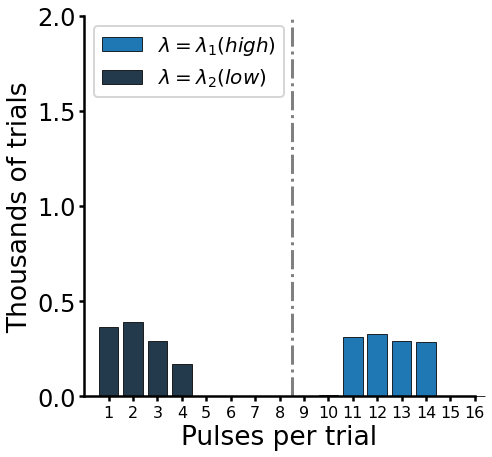

In [221]:
fig = plt.figure(figsize=(7,7))

#plt.subplot(1,2,1)

bin_counts = np.zeros((num_bins,))
for i in range(len(bin_counts_list)):
    bin_counts += bin_counts_list[i]
plt.bar(pulse_bins[half_num_bins:16],bin_counts_2_5[half_num_bins:16]/1000,color=blue_palette[0], 
        edgecolor = 'black', linewidth=0.8, clip_on=False)
plt.bar(pulse_bins[:half_num_bins],bin_counts_2_5[:half_num_bins]/1000,color=blue_palette[6], 
        edgecolor = 'black', linewidth=0.8, clip_on=False)
plt.legend(['$\lambda=\lambda_1(high)$','$\lambda=\lambda_2(low)$'], fontsize=20)
plt.grid(False)
plt.xlim(0,16)
plt.ylim(0,2)

plt.xticks(np.linspace(1,16,16), fontsize = 16)#, rotation=70)
plt.axvline(x=8.5,color='gray',linestyle='-.')
plt.xlabel('Pulses per trial')
plt.ylabel('Thousands of trials')
plt.tick_params(axis='both', length=5, color='black', direction = 'out')
sns.despine(right=True, top=True)
fig.savefig(savepath_svg + 'Histogram_of_trials_2_5s_1to6.svg',transparent=True, format='svg', bbox_inches='tight')
fig.savefig(savepath_png + 'Histogram_of_trials_2_5s_1to6.png',transparent=True, format='png', bbox_inches='tight')
fig.savefig(savepath_pdf + 'Histogram_of_trials_2_5s_1to6.pdf',transparent=True, format='pdf', bbox_inches='tight')

plt.show()

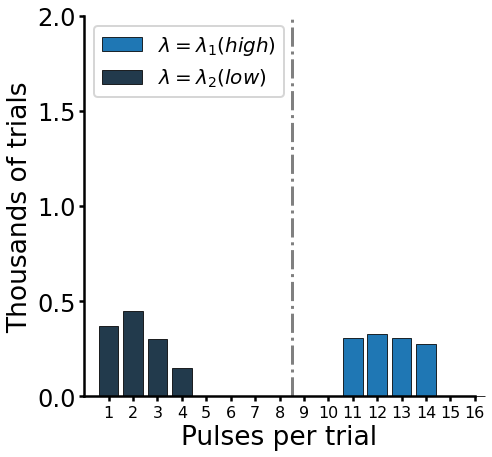

In [222]:
fig = plt.figure(figsize=(7,7))

#plt.subplot(1,2,1)

bin_counts = np.zeros((num_bins,))
for i in range(len(bin_counts_list)):
    bin_counts += bin_counts_list[i]
plt.bar(pulse_bins[half_num_bins:16],bin_counts_5[half_num_bins:16]/1000,color=blue_palette[0], 
        edgecolor = 'black', linewidth=0.8, clip_on=False)
plt.bar(pulse_bins[:half_num_bins],bin_counts_5[:half_num_bins]/1000,color=blue_palette[6], 
        edgecolor = 'black', linewidth=0.8, clip_on=False)
plt.legend(['$\lambda=\lambda_1(high)$','$\lambda=\lambda_2(low)$'], fontsize=20)
plt.grid(False)
plt.xlim(0,16)
plt.ylim(0,2)

plt.xticks(np.linspace(1,16,16), fontsize = 16)#, rotation=70)
plt.axvline(x=8.5,color='gray',linestyle='-.')
plt.xlabel('Pulses per trial')
plt.ylabel('Thousands of trials')
plt.tick_params(axis='both', length=5, color='black', direction = 'out')
sns.despine(right=True, top=True)
fig.savefig(savepath_svg + 'Histogram_of_trials_5s_1to6.svg',transparent=True, format='svg', bbox_inches='tight')
fig.savefig(savepath_png + 'Histogram_of_trials_5s_1to6.png',transparent=True, format='png', bbox_inches='tight')
fig.savefig(savepath_pdf + 'Histogram_of_trials_5s_1to6.pdf',transparent=True, format='pdf', bbox_inches='tight')

plt.show()

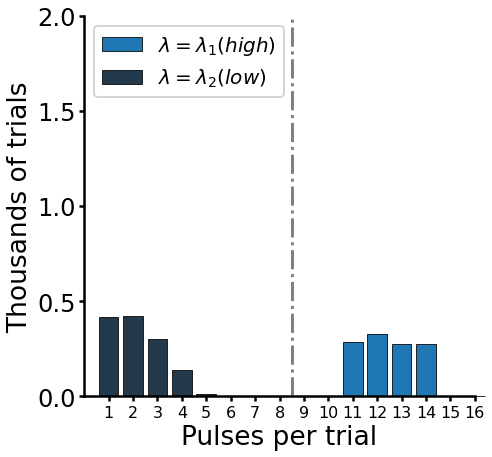

In [223]:
fig = plt.figure(figsize=(7,7))

#plt.subplot(1,2,1)

bin_counts = np.zeros((num_bins,))
for i in range(len(bin_counts_list)):
    bin_counts += bin_counts_list[i]
plt.bar(pulse_bins[half_num_bins:16],bin_counts_10[half_num_bins:16]/1000,color=blue_palette[0], 
        edgecolor = 'black', linewidth=0.8, clip_on=False)
plt.bar(pulse_bins[:half_num_bins],bin_counts_10[:half_num_bins]/1000,color=blue_palette[6], 
        edgecolor = 'black', linewidth=0.8, clip_on=False)
plt.legend(['$\lambda=\lambda_1(high)$','$\lambda=\lambda_2(low)$'], fontsize=20)
plt.grid(False)
plt.xlim(0,16)
plt.ylim(0,2)

plt.xticks(np.linspace(1,16,16), fontsize = 16)#, rotation=70)
plt.axvline(x=8.5,color='gray',linestyle='-.')
plt.xlabel('Pulses per trial')
plt.ylabel('Thousands of trials')
plt.tick_params(axis='both', length=5, color='black', direction = 'out')
sns.despine(right=True, top=True)
fig.savefig(savepath_svg + 'Histogram_of_trials_10_1to6.svg',transparent=True, format='svg', bbox_inches='tight')
fig.savefig(savepath_png + 'Histogram_of_trials_10_1to6.png',transparent=True, format='png', bbox_inches='tight')
fig.savefig(savepath_pdf + 'Histogram_of_trials_10_1to6.pdf',transparent=True, format='pdf', bbox_inches='tight')

plt.show()